# Projet FixMatch


## I. Importing libraries and setup

First, we import the libraries we will use in the notebook:

In [ ]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform

# os
import os
import path

import random
import numpy as np 

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

Then, we setup the device:

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


We initialize global variables, according to the values in the paper, used in the fixmatch algorithm:

In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

We create the model:

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

Finally, we download the dataset:

In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## II. Convolutional Neural Network - Full Supervised

### II.1. CNN on 100% dataset

In [ ]:
seedEverything()

EPOCHS = 29
SUBSET_PROP = 1.00

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        running_accuracy += 100 * correct / total

        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix({
            "loss": loss.item(),
            "accuracy": 100 * correct / total,
            "lr": current_lr.item()
        })

        if scheduler is not None:
            scheduler.step()

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    train_accuracies.append(running_accuracy / (i+1))
    
    
    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())
        test_accuracies.append(test_accuracy)


In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/sup_100_losses_accuracies.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/sup_100_confusion_matrix.png")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_100.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_100.png")

### II.2 CNN on 10% dataset

In [ ]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.10

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP),
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * EPOCHS))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        running_accuracy += 100 * correct / total

        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix({
            "loss": loss.item(),
            "accuracy": 100 * correct / total,
            "lr": current_lr.item()
        })

        if scheduler is not None:
            scheduler.step()

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    train_accuracies.append(running_accuracy / (i+1))
    
    
    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())
        test_accuracies.append(test_accuracy)


In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/sup_10_losses_accuracies.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/sup_10_confusion_matrix.png")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_10.png")

### II.3 CNN on 5% dataset

In [ ]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP),
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample)))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        running_accuracy += 100 * correct / total

        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix({
            "loss": loss.item(),
            "accuracy": 100 * correct / total,
            "lr": current_lr.item()
        })

        if scheduler is not None:
            scheduler.step()

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    train_accuracies.append(running_accuracy / (i+1))
    
    
    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())
        test_accuracies.append(test_accuracy)


In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/sup_5_losses_accuracies.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/sup_5_confusion_matrix.png")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_5.png")

### II.4 CNN on 1% dataset

In [21]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP) + 1,
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample)))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [22]:
# losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        running_accuracy += 100 * correct / total

        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix({
            "loss": loss.item(),
            "accuracy": 100 * correct / total,
            "lr": current_lr
        })

    if scheduler is not None:
        scheduler.step()

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    train_accuracies.append(running_accuracy / (i+1))
    
    
    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())
        test_accuracies.append(test_accuracy)


Epoch     0:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 18.62%


Epoch     2:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 18.54%


Epoch     3:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 23.78%


Epoch     4:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 28.48%


Epoch     5:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 25.24%


Epoch     6:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 30.39%


Epoch     7:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 33.1%


Epoch     8:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 32.71%


Epoch     9:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.1%


Epoch    10:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 31.12%


Epoch    11:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 32.91%


Epoch    12:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 38.14%


Epoch    13:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.9%


Epoch    14:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.97%


Epoch    15:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 33.22%


Epoch    16:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 33.32%


Epoch    17:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.29%


Epoch    18:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.94%


Epoch    19:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 34.34%


Epoch    20:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.46%


Epoch    21:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 32.79%


Epoch    22:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 31.35%


Epoch    23:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 34.91%


Epoch    24:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.76%


Epoch    25:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.14%


Epoch    26:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.65%


Epoch    27:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.82%


Epoch    28:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.89%


Epoch    29:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.88%


Epoch    30:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.94%


Epoch    31:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.01%


Epoch    32:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.0%


Epoch    33:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 35.96%


Epoch    34:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.04%


Epoch    35:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.09%


Epoch    36:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.12%


Epoch    37:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.07%


Epoch    38:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.1%


Epoch    39:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.13%


Epoch    40:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.19%


Epoch    41:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.22%


Epoch    42:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.2%


Epoch    43:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.17%


Epoch    44:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.2%


Epoch    45:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.25%


Epoch    46:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.32%


Epoch    47:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.36%


Epoch    48:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.35%


Epoch    49:   0%|          | 0/500 [00:00<?, ?batch/s]

Test Accuracy: 36.37%


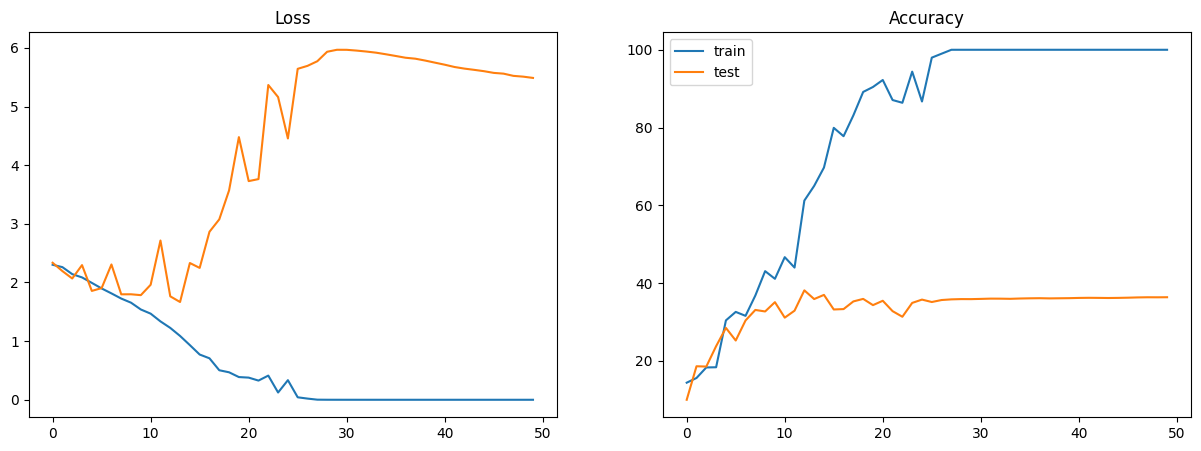

In [23]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/sup_1_losses_accuracies.png")

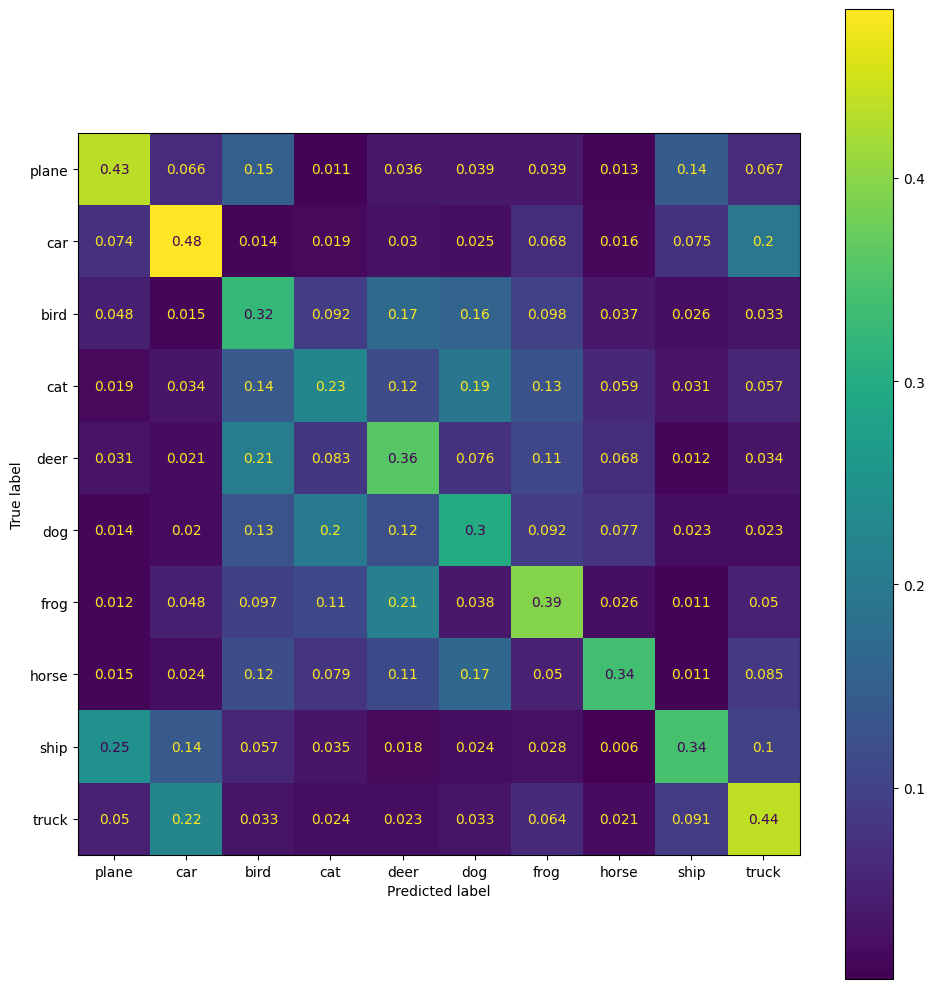

In [24]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/sup_1_confusion_matrix.png")

Test Accuracy: 36.37%


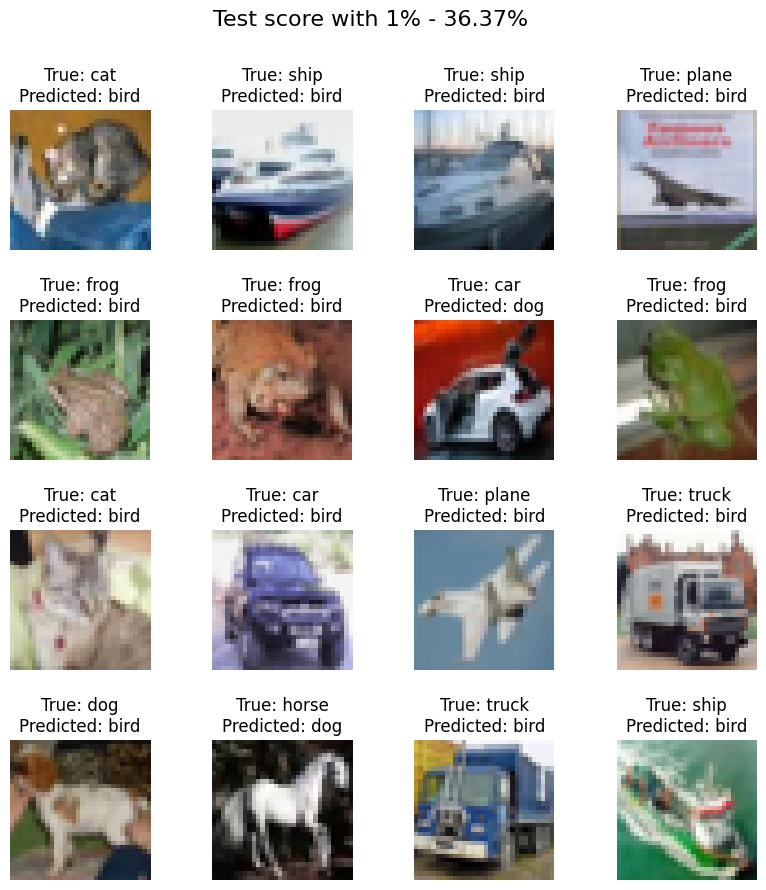

In [25]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_1.png")